In [2]:
import cv2

def downsample(img, factor=0.1):
    if img.shape[0] > img.shape[1]:  # If height is greater than width
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return cv2.resize(img, (int(img.shape[1] * factor), int(img.shape[0] * factor)), interpolation=cv2.INTER_AREA)

In [3]:
# Here's a complete script to calibrate your camera using the captured ArUco images:
import cv2
import numpy as np
from tqdm import tqdm

# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

# Define the 3D world coordinates of the corners of the ArUco tag
# Assuming the tag is 60mm x 60mm (0.06m x 0.06m)
tag_size = 0.06
objp = np.array([
    [0, 0, 0],
    [tag_size, 0, 0],
    [tag_size, tag_size, 0],
    [0, tag_size, 0]
], dtype=np.float32)
# Prepare lists to hold the 3D points and 2D points from all images
objpoints = []  # 3D points in the world coordinate system
imgpoints = []  # 2D points in the image plane
# Loop through all calibration images, globbing
import glob
image_files = glob.glob('data/0p/*.jpg')  # Adjust the path and extension as needed
for image_file in tqdm(image_files, desc="Processing images"):
    # Read the image
    image = cv2.imread(image_file)
    # rotate the img if needed
    image = downsample(image, factor=0.1)  # Downsample the image
    
    # Detect ArUco markers in the image
    corners, ids, _ = detector.detectMarkers(image)
    # Check if any markers were detected
    if ids is not None:
        for i in range(len(ids)):
            # Append the 3D points and corresponding 2D points
            objpoints.append(objp)  # Same 3D points for each tag
            imgpoints.append(corners[i][0])  # Corners of the detected tag
    else:
        print(f"No tags detected in {image_file}, skipping.")

# Perform camera calibration
if len(objpoints) > 0 and len(imgpoints) > 0:
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)
    print("Camera matrix:\n", mtx)
    print("Distortion coefficients:\n", dist)

Processing images: 100%|██████████| 33/33 [00:02<00:00, 14.35it/s]


Camera matrix:
 [[278.09885652   0.         186.71243724]
 [  0.         282.34841928 140.22324758]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[ 0.32626965 -1.32393107 -0.05235842 -0.01921971  2.69948613]]


In [4]:
# Save the calibration results to a file
np.savez('camera_calibration.npz', camera_matrix=mtx, dist_coefficients=dist, rvecs=rvecs, tvecs=tvecs)

In [5]:
# load the calibration results
import numpy as np
calibration_data = np.load('camera_calibration.npz')
camera_matrix = calibration_data['camera_matrix']
dist_coefficients = calibration_data['dist_coefficients']
rvecs = calibration_data['rvecs']
tvecs = calibration_data['tvecs']

In [13]:
"""
 Now that you have calibrated your camera, you can use those intrinsic parameters to estimate the camera pose (position and orientation) for each image of your object. As discussed in lecture, this is the classic Perspective-n-Point (PnP) problem: given a set of 3D points in world coordinates and their corresponding 2D projections in an image, we want to find the camera's extrinsic parameters (rotation and translation).

For each image in your object scan, you'll detect the single ArUco tag and use cv2.solvePnP() to estimate the camera pose. Here's what you need:

Inputs to solvePnP:

    objectPoints (numpy array of shape (N, 3) or (N, 1, 3)): The 3D coordinates of the ArUco tag corners in world space. Since you know the physical size of your printed tag, you can define these coordinates. For example, if your tag is 0.02m × 0.02m, you might define the 4 corners as: [(0,0,0), (0.02,0,0), (0.02,0.02,0), (0,0.02,0)] in meters, with the tag lying flat on the z=0 plane.
    imagePoints (numpy array of shape (N, 2) or (N, 1, 2)): The detected 2D pixel coordinates of the tag corners in the image (from detectMarkers()). You'll need to reshape the corners array from detectMarkers to match this shape.
    cameraMatrix (numpy array of shape (3, 3)): The intrinsic matrix K that you computed in Part 0.1 (contains focal length and principal point)
    distCoeffs (numpy array or None): The distortion coefficients from calibration

Output from solvePnP:

    success (bool): Whether the pose estimation succeeded
    rvec (numpy array of shape (3, 1)): Axis-Angle rotation vector (can be converted to a 3×3 rotation matrix using cv2.Rodrigues())
    tvec (numpy array of shape (3, 1)): Translation vector

Together, the rotation matrix R (from rvec) and translation vector tvec form the camera's extrinsic matrix, which describes where the camera is positioned and oriented relative to the ArUco tag's coordinate system (which we're treating as the world origin). Note: OpenCV's solvePnP() returns the world-to-camera transformation; you will need to invert this to get the camera-to-world (c2w) matrix for visualization and Part 0.4.

Important: Just like in Part 0.1, make sure your code handles cases where the tag isn't detected in some images. You should skip those images rather than letting your code crash. 
"""

import cv2
import numpy as np
import glob
from tqdm import tqdm

# Files are in /data/tea/.jpg
image_files = glob.glob('data/teap/*.jpg')  # Adjust the path and extension as needed

images = []
for image_file in tqdm(image_files, desc="Loading images"):
    img = cv2.imread(image_file)
    img = downsample(img, factor=0.1)  # Downsample the image
    images.append(img)

# Load camera calibration results
calibration_data = np.load('camera_calibration.npz')
camera_matrix = calibration_data['camera_matrix']
dist_coefficients = calibration_data['dist_coefficients']
# Define the 3D world coordinates of the corners of the ArUco tag
tag_size = 0.06  # Adjust based on your tag size
objp = np.array([
    [0, 0, 0],
    [tag_size, 0, 0],
    [tag_size, tag_size, 0],
    [0, tag_size, 0]
], dtype=np.float32)
# Create ArUco dictionary and detector parameters (4x4 tags)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)
# List to hold camera poses
camera_poses = []
for image in tqdm(images, desc="Processing images"):
    # Detect ArUco markers in the image
    corners, ids, _ = detector.detectMarkers(image)
    if ids is not None:
        for i in range(len(ids)):
            # Get the 2D pixel coordinates of the detected tag corners
            img_points = corners[i][0].reshape(-1, 2)  # Shape (4, 2)
            # Estimate the camera pose using solvePnP
            success, rvec, tvec = cv2.solvePnP(objp, img_points, camera_matrix, dist_coefficients)
            if success:
                # Convert rotation vector to rotation matrix
                R, _ = cv2.Rodrigues(rvec)
                # Invert to get camera-to-world transformation
                c2w_R = R.T
                c2w_t = -R.T @ tvec
                c2w = np.eye(4)
                c2w[:3, :3] = c2w_R
                c2w[:3, 3] = c2w_t.flatten()
                camera_poses.append(c2w)
            else:
                print(f"Pose estimation failed for {image_file}")
    else:
        print(f"No tags detected in {image_file}, skipping.")
# Save camera poses to a file
np.savez('camera_poses.npz', camera_poses=camera_poses)

Processing images: 100%|██████████| 35/35 [00:00<00:00, 419.55it/s]


In [12]:
import viser
import numpy as np
import time

H = 300
W = 400

server = viser.ViserServer(share=True, port=8083)
# Example of visualizing a camera frustum (in practice loop over all images)
# c2w is the camera-to-world transformation matrix (3x4), and K is the camera intrinsic matrix (3x3)
for i, (c2w, img) in enumerate(zip(camera_poses, images)):
    server.scene.add_camera_frustum(
        f"/cameras/{i}", # give it a name
        fov=2 * np.arctan2(H / 2, camera_matrix[0, 0]), # field of view
        aspect=W / H, # aspect ratio
        scale=0.02, # scale of the camera frustum change if too small/big
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz, # orientation in quaternion format
        position=c2w[:3, 3], # position of the camera
        image=img # image to visualize
    )

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

╭────── viser (listening *:8084) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8084   │
│   Websocket │ ws://localhost:8084     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://blend-bulb.share.viser.studio

(viser) Connection opened (0, 1 total), 146 persistent messages

(viser) Disconnected from share URL

KeyboardInterrupt: 

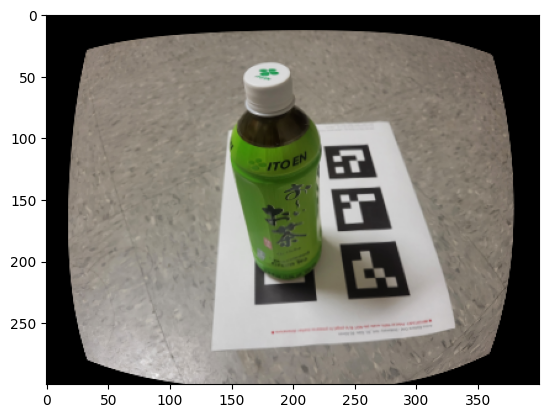

[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.           1.        ]]
[[476.30527041   0.         211.80233881]
 [  0.         512.68144317 142.2497367 ]
 [  0.           0.        

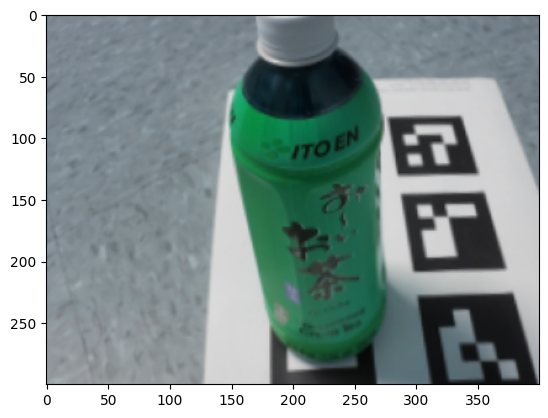

In [ ]:
import cv2
import matplotlib.pyplot as plt
undistorted_imgs = []
for img in images:
    undistorted_img = cv2.undistort(img, camera_matrix, dist_coefficients)
    # Save or display the undistorted image using skimage
    if not undistorted_imgs:
        plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        plt.show()
        im1 = undistorted_img
    undistorted_imgs.append(undistorted_img)

import cv2

# Example: Handling black boundaries from undistortion
h, w = img.shape[:2]
# alpha=1 keeps all pixels (more black borders), alpha=0 crops maximally
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coefficients, (w, h), alpha=0, newImgSize=(w, h)
)
undistorted_img = cv2.undistort(img, camera_matrix, dist_coefficients, None, new_camera_matrix)

# Crop to the valid region of interest
x, y, w_roi, h_roi = roi
undistorted_img = undistorted_img[y:y+h_roi, x:x+w_roi]

# Update the principal point to account for the crop offset
new_camera_matrix[0, 2] -= x  # cx
new_camera_matrix[1, 2] -= y  # cy

again = []
for img in undistorted_imgs:
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
        camera_matrix, dist_coefficients, (w, h), alpha=0, newImgSize=(w, h)
    )
    undistorted_img = cv2.undistort(img, camera_matrix, dist_coefficients, None, new_camera_matrix)
    if not again:
        plt.imshow(undistorted_img)
    again.append(undistorted_img)
    new_camera_matrix[0, 2] -= x  # cx
    new_camera_matrix[1, 2] -= y

In [16]:
"""
 After undistorting all your images, you'll need to save everything in a .npz file format that matches what's expected for the NeRF training code. You should split your images into training, validation, and test sets, then save using the following keys:

    images_train: numpy array of shape (N_train, H, W, 3) containing your undistorted training images (0-255 range, will be normalized when loaded)
    c2ws_train: numpy array of shape (N_train, 4, 4) containing the camera-to-world transformation matrices for training images
    images_val: numpy array of shape (N_val, H, W, 3) for validation images
    c2ws_val: numpy array of shape (N_val, 4, 4) for validation camera poses
    c2ws_test: numpy array of shape (N_test, 4, 4) for test camera poses (used for novel view rendering)
    focal: float representing the focal length from your camera intrinsics (assuming fx = fy)
"""

images_train = np.array(images)  # First 80% for training
c2ws_train = np.array(camera_poses)
images_val = np.array(images[int(0.8 * len(images)):])  # Next 20% for validation
c2ws_val = np.array(camera_poses[int(0.8 * len(camera_poses)):]) # Next 10% for validation

np.savez('my_data.npz',
         images_train=images_train,
         c2ws_train=c2ws_train,
         images_val=images_val,
         c2ws_val=c2ws_val,
            K=new_camera_matrix)  # Assuming fx = fy
            

In [17]:
c2ws_train[0]

array([[-0.99739472,  0.06305066,  0.03504846,  0.11351628],
       [-0.02693656, -0.77623649,  0.62986613, -0.12897446],
       [ 0.06691936,  0.62728106,  0.77591254, -0.33858637],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])